# Graph representation is an accurate representation of the Rulebooks.
Notebook showing that using title and subtitle to represent the Handbook doesn't lose meaning.

This is done by looking at the mean semantic similarity of sentences under the same 
section. It is compared to randomly sampling sentences from the Handbooks to show 
that same sections have a bigger similarity.

In [1]:
from sentence_transformers import SentenceTransformer, util
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from collections import defaultdict
#style.use('default')
embedder = SentenceTransformer("../models/custom_embedder")

/home/mattmdjaga/anaconda3/envs/rssb_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data and for each section we get all the sentences under it. 

3.1, 3.2 and 3.3 would all be considered the same section.

In [3]:
data = pickle.load(open('../data/handbooks_parts.pt','rb'))
res = defaultdict(list)
for x in data:
    title = x['title'] + ' ' + x['sub_title'] + ' '
    section = ''
    i = 0
    if x['section'][i].isnumeric():
        while x['section'][i].isnumeric():
            section += x['section'][i]
            i += 1
        title += section
        res[title].append(x['sentence'])

Computing the mean variance of the semantic similarity of each section.

In [4]:
# For each sentence in the values of the dictionary, calculate the cosine similarity between the sentence and the other senteces in that key
sim = defaultdict(list)
for key, vals in res.items():
    n = len(vals)
    embeddings = []
    for i in range(n):
        embeddings.append(embedder.encode(vals[i], convert_to_tensor=False))
    for i in range(0,n-1):
        for j in range(i+1,n):
            sim[key].append(util.cos_sim(embeddings[i], embeddings[j]).item())
# For each key, calculate the mean of the cosine similarities and plot it in a histogram
mean_sim = []
for key, vals in sim.items():
    mean_sim.append(np.mean(vals))

Repeating the steps for randomly sampled sentences.

Each batch has 10 samples to end up with a similar number of overall section/ batches.

In [5]:
all_sents = [x for vals in res.values() for x in vals]
# randomly shuffle the list of all_sents and then group it in batches of 5
np.random.shuffle(all_sents)

In [6]:
batches = [all_sents[i:i+10] for i in range(0, len(all_sents), 10)]   
# For each batch, calculate the cosine similarity between the batch and store it in the dictionary
sim_rand = defaultdict(list)
for batch_id, batch in enumerate(batches):
    embeddings = []
    for i in range(len(batch)):
        embeddings.append(embedder.encode(batch[i], convert_to_tensor=False))
    for i in range(0,len(batch)-1):
        for j in range(i+1,len(batch)):
            sim_rand[str(batch_id)].append(util.cos_sim(embeddings[i], embeddings[j]).item())
            
# For each key, calculate the mean of the cosine similarities and plot it in a histogram
mean_sim_rand = []
for key, vals in sim_rand.items():
    mean_sim_rand.append(np.mean(vals))

Plotting the results

/home/mattmdjaga/anaconda3/envs/rssb_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mattmdjaga/anaconda3/envs/rssb_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


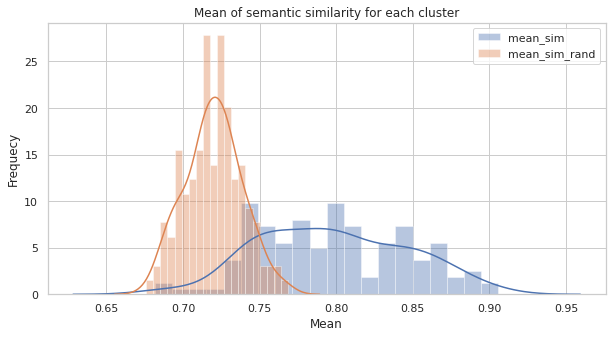

In [8]:
# Plot mean_sim and mean_sim_rand on the same histogram, and make the plot look nice using seaborn
import seaborn as sns
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,5))
sns.distplot(mean_sim, bins=20, label='mean_sim')
sns.distplot(mean_sim_rand, bins=20, label='mean_sim_rand')
plt.title('Mean of semantic similarity for each cluster')
plt.xlabel('Mean')
plt.ylabel('Frequecy')
plt.legend()
plt.show()
#fig.savefig('mean_sim.png')
